# auto reload

In [1]:
%load_ext autoreload
%autoreload 2

# import

In [382]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
# from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Make dataset class

In [3]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, annotation_path, img_dir, img_size): # name2idx is encode classname as int, name2idx is encoder.
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = None
        self.img_data_all,  self.gt_classes_all, self.gt_bboxes_all = self.get_data()

    def __len__(self):
        return len(self.img_data_all)
    
    def __getitem__(self, index):
        return self.img_data_all[index], self.gt_bboxes_all[index], self.gt_classes_all[index]
    
    def scale_bounding_box(self, scale_width, scale_height, boxes_img_raw):
        boxes_img = [[float(i[ind] * scale_width) if ind % 2 == 0 else float(i[ind] * scale_height)
                                   for ind in range(len(i))] for i in boxes_img_raw]
        return boxes_img

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        boxes_all_scale = []
        img_paths, gt_classes_all, gt_boxes_all = parse_annotation(self.annotation_path, self.img_dir) # function from utils.py
        '''
        img_paths: [path1, path2, path3,...]
        gt_class_all: [[class1, class2,..], [class2,..], [class1, class3,..],...]
        gt_boxes_all: [[[x_min, y_min, x_max, y_max], [x_min, y_min, x_max, y_max],...],... ]
        '''
        for index, img_path in enumerate(img_paths):
            if (not img_path) or (not os.path.exists(img_path)):
                continue
            image = io.imread(img_path) # width, height, chanel
            old_width = image.shape[1]
            old_height = image.shape[0]
            # resize
            image = resize(image, self.img_size)

            # after resize image, we need to adjust bounding box data to fit the new image
            boxes_img_scale = self.scale_bounding_box(self.img_size[1]/old_width,
                                                      self.img_size[0]/old_height,
                                                      gt_boxes_all[index])
            boxes_all_scale.append(torch.Tensor(boxes_img_scale))

            # convert to tensor and reshape chanel, width, height
            image = torch.from_numpy(image).permute(2,0,1)
            img_data_all.append(image)

            #encode class name
            self.name2idx = encode_class(gt_classes_all) # make dictionary of class and index of it {'class': index}
            gt_idxs_all.append(torch.Tensor([self.name2idx[class_name]
                                             for class_name in gt_classes_all[index]]))

        #padding bounding box and classes so that elements within (bên trong) them are the same size
        gt_idxs_all_padded = pad_sequence(gt_idxs_all, batch_first= True, padding_value=-1) # batch_first=True -> Batch, maxlenght, dim
        gt_boxes_all_padded = pad_sequence(boxes_all_scale, batch_first=True, padding_value=-1) # nếu batch_first=False -> maxlenght, batch, dim
        
        #stack all image to a Tensor
        imgs_stack = torch.stack(img_data_all, dim=0)
        # dữ liệu ở float32 sẽ đỡ tốn bộ nhớ hơn dữ liệu ở float64(default)
        return imgs_stack.to(dtype=torch.float32), gt_idxs_all_padded, gt_boxes_all_padded

In [4]:
annotations_path = "VOCdevkit/VOC2007/Annotations"
img_size = (200, 200)
img_dir = "VOCdevkit/VOC2007/JPEGImages"

# Create dataset and dataloader

## Dataset

In [5]:
dataset = ObjectDetectionDataset(annotations_path, img_dir, img_size)

- All class and it's index

In [6]:
dataset.name2idx

{'pottedplant': 0,
 'car': 1,
 'dog': 2,
 'chair': 3,
 'cat': 4,
 'horse': 5,
 'diningtable': 6,
 'bus': 7,
 'train': 8,
 'person': 9,
 'sheep': 10,
 'bottle': 11,
 'cow': 12,
 'motorbike': 13,
 'tvmonitor': 14,
 'bird': 15,
 'sofa': 16,
 'bicycle': 17,
 'aeroplane': 18,
 'boat': 19}

In [7]:
idx2name = decode_class(dataset.name2idx)
idx2name.update({-1: ''})

## dataset example

In [8]:
dataset.__getitem__(0)

(tensor([[[0.0383, 0.0413, 0.0413,  ..., 0.6515, 0.6428, 0.6372],
          [0.2125, 0.1444, 0.0865,  ..., 0.6474, 0.6458, 0.6457],
          [0.3854, 0.3963, 0.4180,  ..., 0.6618, 0.6588, 0.6544],
          ...,
          [0.0838, 0.0793, 0.0902,  ..., 0.2995, 0.2785, 0.2416],
          [0.1096, 0.1198, 0.2132,  ..., 0.2639, 0.2317, 0.2302],
          [0.1875, 0.2816, 0.2998,  ..., 0.2324, 0.2344, 0.2669]],
 
         [[0.0410, 0.0431, 0.0524,  ..., 0.7367, 0.7359, 0.7352],
          [0.2329, 0.1527, 0.0865,  ..., 0.7560, 0.7473, 0.7436],
          [0.4492, 0.4681, 0.4853,  ..., 0.7606, 0.7546, 0.7460],
          ...,
          [0.0392, 0.0295, 0.0198,  ..., 0.3528, 0.3150, 0.2746],
          [0.0448, 0.0324, 0.0612,  ..., 0.3150, 0.2818, 0.2750],
          [0.0588, 0.0986, 0.0872,  ..., 0.2785, 0.2931, 0.3222]],
 
         [[0.0420, 0.0416, 0.0429,  ..., 0.7667, 0.7630, 0.7627],
          [0.2418, 0.1634, 0.0962,  ..., 0.7760, 0.7720, 0.7709],
          [0.4607, 0.4769, 0.4937,  ...,

In [9]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 200, 200])

In [10]:
dataset.__getitem__(0)[1]

tensor([[ 66.0000, 140.8000, 101.2000, 198.4000],
        [  2.0000, 130.1333,  26.8000, 199.4667],
        [ 96.4000, 103.4667, 118.0000, 159.4667],
        [110.8000,  99.2000, 124.8000, 117.3333],
        [110.8000,  99.2000, 124.8000, 117.3333],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],


(<Figure size 1000x500 with 2 Axes>, <Axes: >)

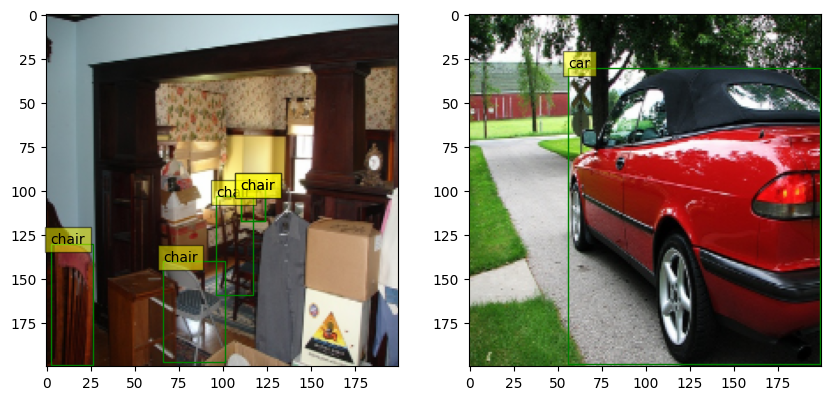

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
display_img([dataset.__getitem__(0)[0], dataset.__getitem__(1)[0]], fig, ax)
display_boundingbox(dataset.__getitem__(0)[1], [idx2name[int(i)] for i in dataset.__getitem__(0)[2]], fig, ax[0])
display_boundingbox(dataset.__getitem__(1)[1], [idx2name[int(i)] for i in dataset.__getitem__(1)[2]], fig, ax[1])

### Visualize image and bounding box for all class of some sample

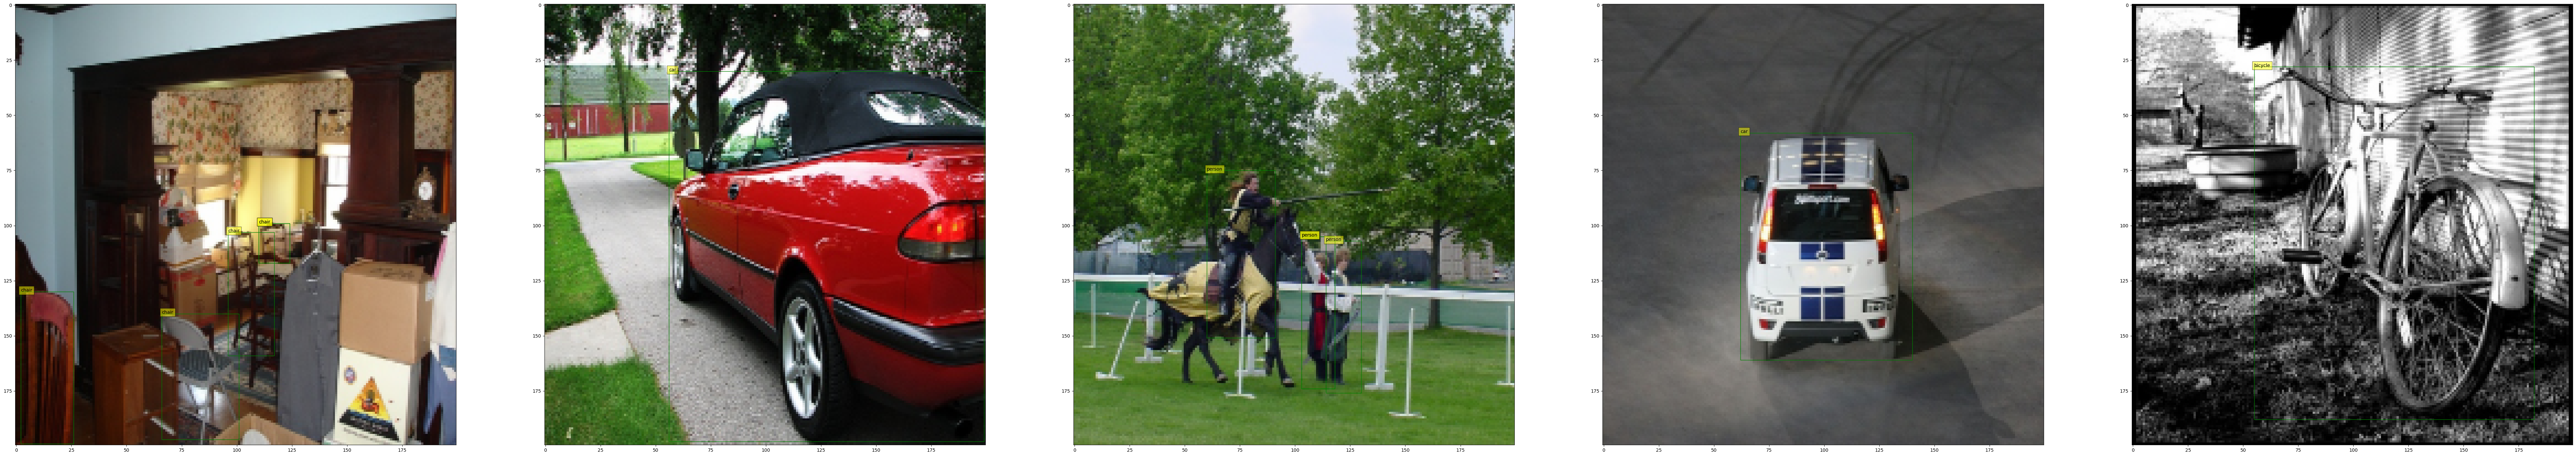

In [13]:
count_tesst = 0
fig, ax = plt.subplots(1, 5 , figsize=(100, 20))
display_img([dataset.__getitem__(index)[0] for index in range(5)], fig, ax)
for index in range(5):
    _, gt_boxes_data, gt_classes_data = dataset.__getitem__(index)
    display_boundingbox(gt_boxes_data, [idx2name[int(i)] for i in gt_classes_data], fig, ax[index])
    count_tesst +=1
    if count_tesst == 6:
        break

## DataLoader

In [263]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# CNN Backbone

- Cho ảnh qua CNN để lấy feature map, chiều của feature map sẽ nhỏ hơn chiều ảnh

In [14]:
from torchvision.models import vgg16, VGG16_Weights
model = vgg16(weights =  VGG16_Weights)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
list(model.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [16]:
feature_extractor = torch.nn.Sequential(*list(model.children())[0][:17])

In [17]:
list(feature_extractor.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

## Visualize example of output feature_extractor

### infomation of data ouput of feature_extractor

In [18]:
img_data_sample, gt_boxes_sample, gt_classes_sample = dataset.__getitem__(0)
feature_out = feature_extractor(img_data_sample)
feature_out.shape


torch.Size([256, 25, 25])

In [19]:
feature_img_chanel, feature_img_height, feature_img_width = feature_out.shape[0], feature_out.shape[1], feature_out.shape[2]
print(feature_img_chanel, feature_img_height, feature_img_width)

256 25 25


### visualize

(<Figure size 2000x500 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

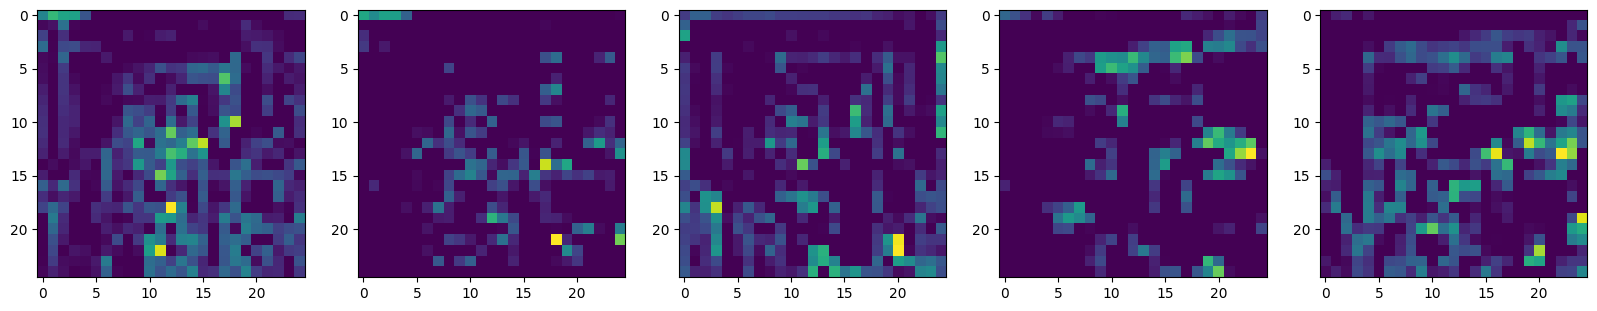

In [20]:
fig1, ax1 = plt.subplots(1, 5, figsize=(20, 5))
display_img([feature_out[i].detach().numpy() for i in range(5)], fig1, ax1)

# Grid Map

- vẽ ra các anchor (các điểm) ở ảnh đầu vào mà số anchor ở chiều rộng bằng width của ảnh feature map và số anchor ở chiều dài bằng height của ảnh feature map

In [21]:
scale_center = img_size[0]/feature_img_height
centers_x, centers_y = generate_anchor_centers((feature_img_height, feature_img_width), scale_center)
centers = [[x, y] for x in centers_x for y in centers_y]
print(len(centers))
bboxes = generate_anchor_boxes(centers, img_size, img_size[0]/feature_img_height) # mỗi ảnh sẽ có valid bboxes generate ban đầu giống nhau 
# x_top_left, y_top_left, width, height
len(bboxes)

625


529

- Lấy tất cả bboxes của các anchor (kể cả anchor box không hợp lệ)

In [95]:
all_bboxes = generate_all_anchor_boxes(centers, img_size[0]/feature_img_height)
all_bboxes_tensor = torch.stack(all_bboxes, dim=0)
all_bboxes_tensor.shape

torch.Size([625, 9, 4])

## display valid bboxes

KeyboardInterrupt: 

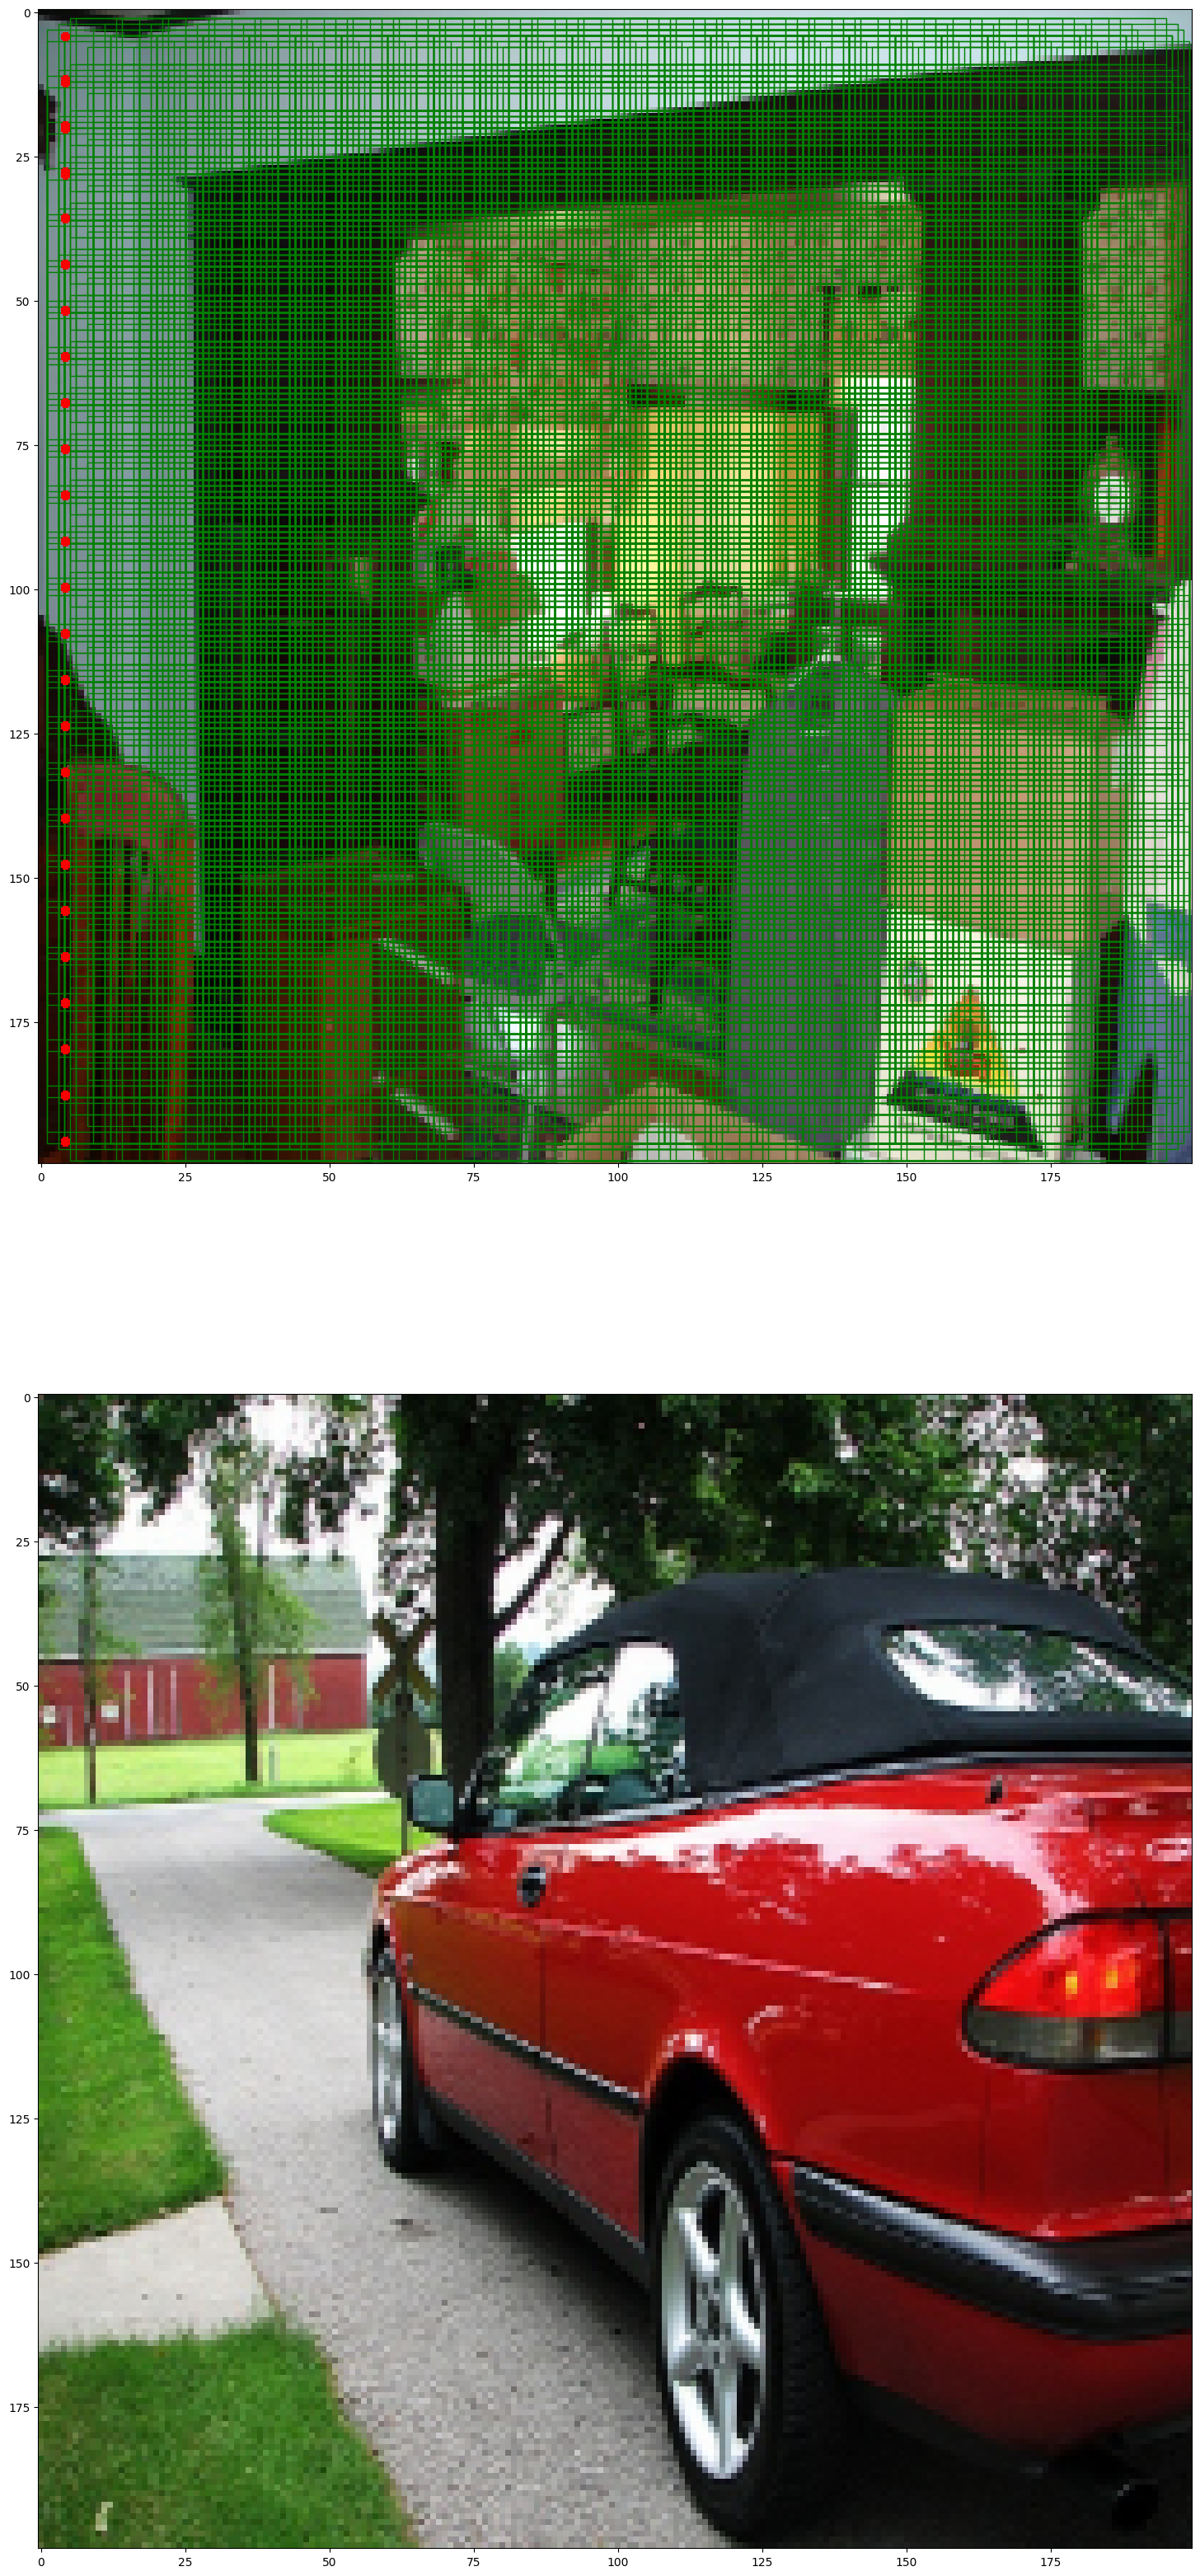

In [97]:
fig1, axes1 = plt.subplots(2, 1, figsize=(80,40))
display_img([dataset.__getitem__(index)[0] for index in range(2)], fig1, axes1)
for index in range(2):
    for bboxe in bboxes:
        bboxe = ops.box_convert(bboxe, in_fmt='xywh', out_fmt='xyxy')
        display_boundingbox(bboxe, ['' for i in range(bboxe.shape[0])], fig1, axes1[index])
    display_anchor_centers(centers_x, centers_y, fig1, axes1[index])
    display_anchor_centers(centers_x, centers_y, fig1, axes1[index])

## Assign a label and location

In [23]:
gt_boxes_sample.shape

torch.Size([42, 4])

In [150]:
gt_boxes_sample, gt_boxes_sample.shape

(tensor([[ 66.0000, 140.8000, 101.2000, 198.4000],
         [  2.0000, 130.1333,  26.8000, 199.4667],
         [ 96.4000, 103.4667, 118.0000, 159.4667],
         [110.8000,  99.2000, 124.8000, 117.3333],
         [110.8000,  99.2000, 124.8000, 117.3333],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  

In [25]:
gt_appear_in_an_img = gt_boxes_sample[torch.where(gt_boxes_sample[:,0] != -1)[0]]
gt_appear_in_an_img

tensor([[ 66.0000, 140.8000, 101.2000, 198.4000],
        [  2.0000, 130.1333,  26.8000, 199.4667],
        [ 96.4000, 103.4667, 118.0000, 159.4667],
        [110.8000,  99.2000, 124.8000, 117.3333],
        [110.8000,  99.2000, 124.8000, 117.3333]])

In [26]:
bboxes

[tensor([[ 6.,  1., 11., 22.],
         [ 4.,  4., 16., 16.]]),
 tensor([[ 6.,  9., 11., 22.],
         [ 4., 12., 16., 16.]]),
 tensor([[ 6., 17., 11., 22.],
         [ 4., 20., 16., 16.],
         [ 1.,  5., 22., 45.]]),
 tensor([[ 6., 25., 11., 22.],
         [ 4., 28., 16., 16.],
         [ 1., 13., 22., 45.]]),
 tensor([[ 6., 33., 11., 22.],
         [ 4., 36., 16., 16.],
         [ 1., 21., 22., 45.]]),
 tensor([[ 6., 41., 11., 22.],
         [ 4., 44., 16., 16.],
         [ 1., 29., 22., 45.]]),
 tensor([[ 6., 49., 11., 22.],
         [ 4., 52., 16., 16.],
         [ 1., 37., 22., 45.]]),
 tensor([[ 6., 57., 11., 22.],
         [ 4., 60., 16., 16.],
         [ 1., 45., 22., 45.]]),
 tensor([[ 6., 65., 11., 22.],
         [ 4., 68., 16., 16.],
         [ 1., 53., 22., 45.]]),
 tensor([[ 6., 73., 11., 22.],
         [ 4., 76., 16., 16.],
         [ 1., 61., 22., 45.]]),
 tensor([[ 6., 81., 11., 22.],
         [ 4., 84., 16., 16.],
         [ 1., 69., 22., 45.]]),
 tensor([[ 6., 89

In [27]:
location_boxes, iou_boxes, label_boxes = calculate_location_iou_label(bboxes, gt_appear_in_an_img)
'''
localtion_boxes: tensor([tensor[x_top_left, y_top_left, dw, dh],...]) dim = N x 4 với N là số anchor boxes
iou_boxes: tensor([tensor[iou1, iou2,...],...]) dim = N X M với M là số ground truth boxes của ảnh
label_boxes: tensor([label1, label2,...]) dim = N
'''

6.0 1.0 17.0 23.0
tensor([ 66.0000, 140.8000, 101.2000, 198.4000])
-----

iou: 0.0
6.0 1.0 17.0 23.0
tensor([  2.0000, 130.1333,  26.8000, 199.4667])
-----

iou: 0.0
6.0 1.0 17.0 23.0
tensor([ 96.4000, 103.4667, 118.0000, 159.4667])
-----

iou: 0.0
6.0 1.0 17.0 23.0
tensor([110.8000,  99.2000, 124.8000, 117.3333])
-----

iou: 0.0
6.0 1.0 17.0 23.0
tensor([110.8000,  99.2000, 124.8000, 117.3333])
-----

iou: 0.0
4.0 4.0 20.0 20.0
tensor([ 66.0000, 140.8000, 101.2000, 198.4000])
-----

iou: 0.0
4.0 4.0 20.0 20.0
tensor([  2.0000, 130.1333,  26.8000, 199.4667])
-----

iou: 0.0
4.0 4.0 20.0 20.0
tensor([ 96.4000, 103.4667, 118.0000, 159.4667])
-----

iou: 0.0
4.0 4.0 20.0 20.0
tensor([110.8000,  99.2000, 124.8000, 117.3333])
-----

iou: 0.0
4.0 4.0 20.0 20.0
tensor([110.8000,  99.2000, 124.8000, 117.3333])
-----

iou: 0.0
6.0 9.0 17.0 31.0
tensor([ 66.0000, 140.8000, 101.2000, 198.4000])
-----

iou: 0.0
6.0 9.0 17.0 31.0
tensor([  2.0000, 130.1333,  26.8000, 199.4667])
-----

iou: 0.0
6.0 

'\nlocaltion_boxes: tensor([tensor[x_top_left, y_top_left, dw, dh],...]) dim = N x 4 với N là số anchor boxes\niou_boxes: tensor([tensor[iou1, iou2,...],...]) dim = N X M với M là số ground truth boxes của ảnh\nlabel_boxes: tensor([label1, label2,...]) dim = N\n'

- lấy tất cả các location, iou, label tương ứng của all_bboxes

In [279]:
img_data_sample, gt_boxes_sample, gt_classes_sample = next(iter(dataloader))

In [298]:
gt_boxes_sample.shape

torch.Size([1, 42, 4])

In [296]:
gt_appear_in_an_img = gt_boxes_sample[0][torch.where(gt_boxes_sample[0][:,0] != -1)[0]]

In [299]:
gt_appear_in_an_img.unsqueeze(0).shape

torch.Size([1, 13, 4])

In [300]:
all_location_boxes, all_iou_boxes, all_label_boxes = calculate_location_iou_label(all_bboxes_tensor, gt_appear_in_an_img.unsqueeze(0))

In [301]:
all_location_boxes.shape, all_iou_boxes.shape, all_label_boxes.shape

(torch.Size([1, 5625, 4]), torch.Size([1, 5625, 13]), torch.Size([1, 5625]))

- Với mỗi ground truth box trong ảnh, tìm ra box có iou cao nhất

In [302]:
gt_argmax_iou = all_iou_boxes[0].argmax(dim=0)
print(gt_argmax_iou)
print(gt_argmax_iou.shape)
gt_max_iou = all_iou_boxes[0][gt_argmax_iou, torch.arange(gt_argmax_iou.shape[0])]
print(gt_max_iou)
print(gt_max_iou.shape)


tensor([ 799,  600, 4893, 3300, 3759, 2094,  771,  975, 1212, 3462, 3921, 4821,
        4821])
torch.Size([13])
tensor([0.7198, 0.7132, 0.5926, 0.5902, 0.7687, 0.3225, 0.4520, 0.4483, 0.3943,
        0.5119, 0.4635, 0.3671, 0.3671])
torch.Size([13])


In [303]:
gt_max_iou 

tensor([0.7198, 0.7132, 0.5926, 0.5902, 0.7687, 0.3225, 0.4520, 0.4483, 0.3943,
        0.5119, 0.4635, 0.3671, 0.3671])

- Tìm những anchor box có điểm iou với gt tương ứng = gt_max_iou tương ứng

In [304]:
gt_max_iou.shape

torch.Size([13])

In [306]:
gt_argmax_iou = torch.where(all_iou_boxes[0] == gt_max_iou)[0]
print(gt_argmax_iou)
print(gt_argmax_iou.shape)

tensor([ 600,  609,  771,  780,  789,  798,  799,  807,  808,  816,  825,  975,
         984,  993, 1212, 1221, 1230, 1239, 1437, 1446, 1455, 1464, 2094, 2103,
        2112, 2121, 2130, 2139, 2148, 2157, 2166, 2175, 2184, 3300, 3462, 3471,
        3480, 3489, 3498, 3507, 3516, 3525, 3759, 3921, 3930, 3939, 3948, 3957,
        3966, 3975, 3984, 4821, 4821, 4830, 4830, 4839, 4839, 4848, 4848, 4857,
        4857, 4866, 4866, 4875, 4875, 4884, 4884, 4893, 4893, 4893, 4902, 4902,
        4902, 4911])
torch.Size([74])


In [307]:
all_location_boxes[0][gt_argmax_iou].shape

torch.Size([74, 4])

-  Với mỗi anchor box trong ảnh, tìm xem anchor đó có điểm iou cao nhất với ground truth box nào

In [308]:
anchor_boxes_argmax_iou = all_iou_boxes[0].argmax(dim=1)
print(anchor_boxes_argmax_iou.shape)
print(anchor_boxes_argmax_iou)
anchor_boxes_max_iou = all_iou_boxes[0][torch.arange(all_iou_boxes[0].shape[0]), anchor_boxes_argmax_iou]
print(anchor_boxes_max_iou)
print(anchor_boxes_max_iou.shape)

torch.Size([5625])
tensor([0, 0, 0,  ..., 2, 2, 2])
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0894, 0.0981, 0.1121])
torch.Size([5625])


In [314]:
anchor_boxes_max_iou[anchor_boxes_max_iou > 0.7]

tensor([0.7132, 0.7132, 0.7198, 0.7198, 0.7687, 0.7433])

- Với mỗi anchor box, lấy chỉ số của ground truth box mà có điểm iou cao nhất với anchor box đó

In [319]:
gt_appear_in_an_img

tensor([[  2.0000,  83.2000,  46.8000, 141.3333],
        [  9.2000,  96.5333,  36.8000, 174.9333],
        [150.4000, 107.7333, 192.8000, 198.4000],
        [108.0000,  92.8000, 129.2000, 165.8667],
        [116.4000, 105.0667, 153.2000, 179.7333],
        [ 52.8000,  23.4667,  98.0000, 179.7333],
        [  3.2000,  48.0000,  45.2000, 168.0000],
        [ 27.6000,  38.9333,  41.6000, 113.6000],
        [ 40.0000,  36.2667,  56.8000, 137.6000],
        [106.4000,  41.6000, 137.6000, 162.6667],
        [122.4000,  49.0667, 160.8000, 177.0667],
        [152.4000,  44.8000, 194.4000, 192.5333],
        [152.4000,  44.8000, 194.4000, 192.5333]])

In [320]:
anchor_boxes_max_iou_coordinates = torch.stack([gt_appear_in_an_img[i] for i in anchor_boxes_argmax_iou])

In [381]:
print(anchor_boxes_max_iou_coordinates.shape)
anchor_boxes_max_iou_coordinates

torch.Size([5625, 4])


tensor([[  2.0000,  83.2000,  46.8000, 141.3333],
        [  2.0000,  83.2000,  46.8000, 141.3333],
        [  2.0000,  83.2000,  46.8000, 141.3333],
        ...,
        [150.4000, 107.7333, 192.8000, 198.4000],
        [150.4000, 107.7333, 192.8000, 198.4000],
        [150.4000, 107.7333, 192.8000, 198.4000]])

In [259]:
a = torch.Tensor([[1,2,3],
                  [3,4,0],
                  [0,0,0],
                  [1,2,3]])
b = torch.Tensor([3,4,0])
torch.where(a == b)

(tensor([1, 1, 1, 2]), tensor([0, 1, 2, 2]))

- gán nhãn pos và neg
- anchor box nào không phải pos và cũng không phải neg thì không dùng để train

In [322]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

In [323]:
all_label_boxes[0][anchor_boxes_max_iou < neg_iou_threshold] = 0
all_label_boxes[0][gt_argmax_iou] = 1
all_label_boxes[0][anchor_boxes_max_iou > pos_iou_threshold] = 1

- Lấy khoảng 1/10 số anchor hợp lệ trong 1 ảnh để tính loss function cho mini-batch

In [324]:
pos_ratio = 0.5
power_of_10 = 0
# while math.pow(10, power_of_10) <= len(location_boxes):
#     power_of_10 += 1
# n_sample = int((len(location_boxes)//math.pow(10,power_of_10 - 1))*math.pow(10,power_of_10 - 2))
n_sample = 64
n_pos = int(n_sample*pos_ratio)
n_pos

32

In [325]:
pos_index = torch.where(all_label_boxes[0] == 1)[0]
if len(pos_index) > n_pos:
    disable_index = torch.randperm(len(pos_index))[n_pos:]
    all_label_boxes[0][pos_index[disable_index]] = -1
pos_index = torch.where(all_label_boxes[0] == 1)[0]

In [326]:
n_neg = n_sample - len(torch.where(all_label_boxes[0] == 1)[0])
neg_index = torch.where(all_label_boxes[0] == 0)[0]
if len(neg_index) > n_neg:
    disable_index = torch.randperm(len(neg_index))[n_neg:]
    all_label_boxes[0][neg_index[disable_index]] = -1
neg_index = torch.where(all_label_boxes[0] == 0)[0]

In [327]:
n_neg

32

In [380]:
all_location_boxes[0][pos_index] == all_location_boxes[0][all_label_boxes[0] == 1]

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True,

In [386]:
calc_gt_offset(bboxes_pos_xyxy, anchor_boxes_max_iou_coordinates[pos_index])

tensor([[ 1.6486e-01,  2.1212e-02, -5.4201e-03,  5.8460e-02],
        [-1.8000e-01,  6.6430e-02,  3.9221e-02,  2.3614e-03],
        [-8.8462e-02, -5.8095e-02, -1.0536e-01,  9.4788e-03],
        [-1.3111e-01,  2.1212e-02, -2.0116e-01,  5.8460e-02],
        [ 1.7869e-01, -1.2347e-01, -7.1338e-02,  9.6037e-02],
        [ 1.7869e-01, -2.0627e-01, -7.1338e-02,  3.4002e-02],
        [-1.5942e-02, -2.9345e-02, -1.9457e-01,  1.6218e-01],
        [-1.5942e-02, -1.2347e-01, -1.9457e-01,  9.6037e-02],
        [-3.9785e-02,  4.3907e-01,  5.2368e-02,  6.5887e-01],
        [-3.9785e-02,  1.5443e-01,  5.2368e-02,  5.0013e-01],
        [-3.9785e-02,  4.1311e-02,  5.2368e-02,  4.2930e-01],
        [-3.9785e-02, -5.7333e-02,  5.2368e-02,  3.6316e-01],
        [-3.9785e-02, -2.8971e-01,  5.2368e-02,  1.8753e-01],
        [-3.9785e-02, -3.5138e-01,  5.2368e-02,  1.3523e-01],
        [-3.9785e-02, -4.0707e-01,  5.2368e-02,  8.5529e-02],
        [-3.9785e-02, -4.5761e-01,  5.2368e-02,  3.8183e-02],
        

- visualize pos_boxes and neg_boxes sample

(<Figure size 3000x1500 with 2 Axes>, <Axes: >)

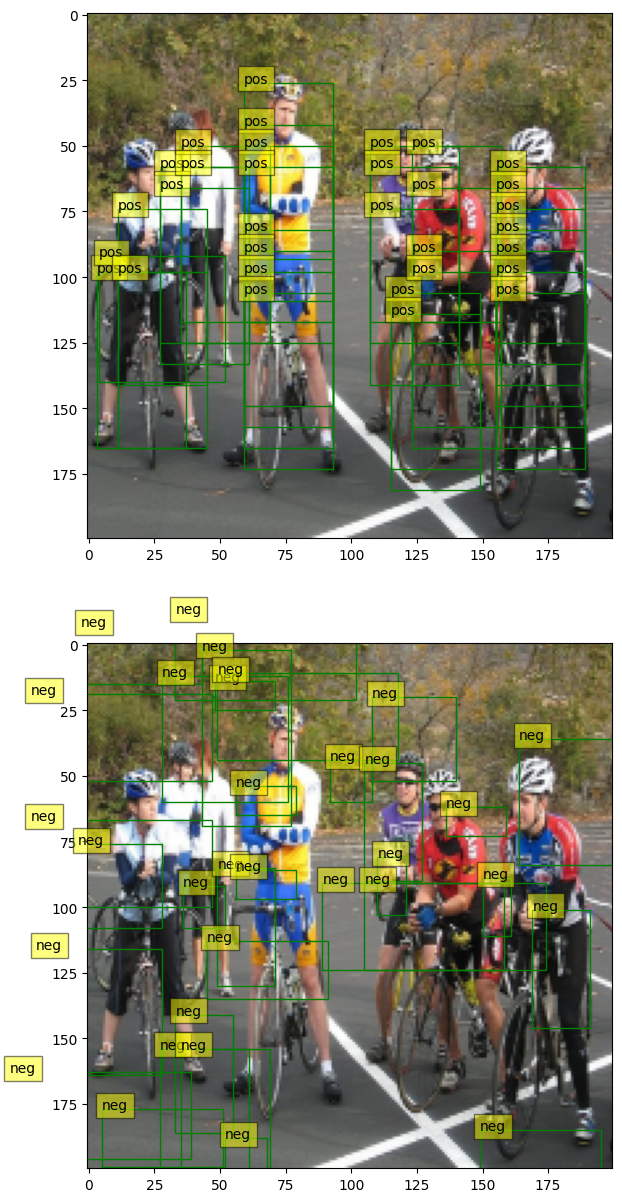

In [328]:
fig2, axes2 = plt.subplots(2, 1, figsize=(30, 15))
display_img([img_data_sample[0] , img_data_sample[0]], fig2, axes2)
bboxes_pos_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 1], in_fmt='xywh', out_fmt='xyxy')
display_boundingbox(bboxes_pos_xyxy, ['pos' for i in range(all_location_boxes[0][all_label_boxes[0] == 1].shape[0])], fig2, axes2[0])
bboxes_neg_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 0], in_fmt='xywh', out_fmt='xyxy')
display_boundingbox(bboxes_neg_xyxy, ['neg' for i in range(all_location_boxes[0][all_label_boxes[0] == 0].shape[0])], fig2, axes2[1])

- Mô hình cần học một bộ offsets để điều chỉnh anchorboxes sao cho gần nhất với gt_box, bộ offsets gồm:
    + t_x, t_y biểu diễn độ dịch chuyển của tâm anchor theo trục x, y
    + t_w, t_h biểu diễn tỷ lệ thay đổi về kích thước của anchor box so với gt box
    + log được dùng để cho mạng dễ học hơn
tránh dự đoán giá trị bbox ở phạm vi quá lớn dẫn đến khó tối ưu hóa

- convert coordinates anchor box từ x_top_left, y_top_left, w, h về x_center, y center, w, h để tính 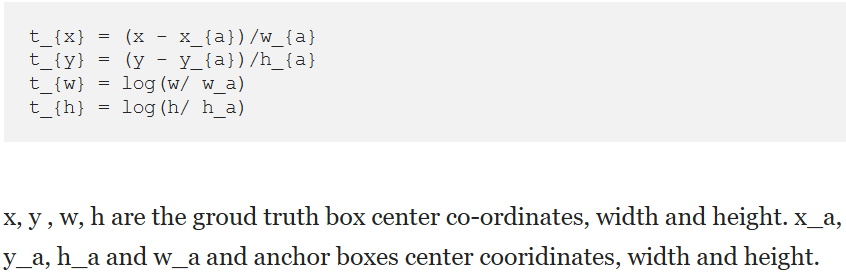

In [84]:
width_anchor_boxes = all_location_boxes[0][:,2] # size = torch.size([N]) với N là số anchor boxes 
height_anchor_boxes = all_location_boxes[0][:,3]
centers_x = all_location_boxes[0][:,0] + width_anchor_boxes/2
centers_y = all_location_boxes[0][:,1] + height_anchor_boxes/2

width_gt_boxes_anchor = anchor_boxes_max_iou_coordinates[:,2]
height_gt_boxes_anchor = anchor_boxes_max_iou_coordinates[:,3]
centers_x_gt = anchor_boxes_max_iou_coordinates[:,0] + width_gt_boxes_anchor/2
centers_y_gt = anchor_boxes_max_iou_coordinates[:,1] + height_gt_boxes_anchor/2


- Chỉnh sửa để width và height > 0 để tránh trường hợp chia cho 0 trong công thức

In [85]:
eps = torch.finfo(width_anchor_boxes.dtype).eps
width_anchor_boxes = torch.clamp_min(width_anchor_boxes, eps) # clamp_min: giữ giá trị nhỏ nhất là eps, tránh = 0
height_anchor_boxes = torch.clamp_min(height_anchor_boxes, eps)

In [86]:
ty = (centers_y_gt - centers_y) / height_anchor_boxes
tx = (centers_x_gt - centers_x) / width_anchor_boxes
th = torch.log(height_gt_boxes_anchor / height_anchor_boxes)
tw = torch.log(width_gt_boxes_anchor / width_anchor_boxes)
anchor_locations = torch.stack([tx, ty, tw, th], dim=1)
print(anchor_locations.shape)
anchor_locations

torch.Size([5625, 4])


tensor([[10.1909, 10.7273,  2.2192,  2.1992],
        [ 7.0375, 14.7500,  1.8445,  2.5177],
        [ 4.8739, 21.4091,  1.4816,  2.8924],
        ...,
        [-2.3353,  0.6642,  1.0907,  1.0856],
        [-1.6542,  0.9167,  0.7459,  1.4191],
        [-1.1435,  1.3485,  0.3830,  1.7938]])

In [87]:
anchor_labels = all_label_boxes

# Region proposal network

## Proposal Module

In [102]:
class ProposalModule(nn.Module):
    def __init__(self):
        super(ProposalModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # 256x25x25 -> 256x25x25
        self.cls_logist = nn.Conv2d(in_channels=256, out_channels=9*2, kernel_size=1, stride=1, padding=0) # 256x25x25 -> 18x25x25
        self.bbox_reg = nn.Conv2d(in_channels=256, out_channels=9*4, kernel_size=1, stride=1, padding=0) # 256x25x25 -> 36x25x25
        
    def forward(self, feature_map, positive_anchorbox_index=None, negative_anchorbox_index=None, positive_anchorbox_coordinates=None):
        x = self.conv1(feature_map)
        cls_logist = self.cls_logist(x)
        bbox_reg = self.bbox_reg(x)
        mode = 'train'
        if positive_anchorbox_index is None or negative_anchorbox_index is None or positive_anchorbox_coordinates is None:
            mode = 'eval'
        if mode == 'eval':
            return cls_logist, bbox_reg
        # get logist score of positive and negative anchor boxes
        cls_logist_pos = cls_logist.contiguous().view(-1, 2)[positive_anchorbox_index]
        cls_logist_neg = cls_logist.contiguous().view(-1, 2)[negative_anchorbox_index]

        # get offsets for positive anchor boxes
        offsets_pos = bbox_reg.contiguous().view(-1, 4)[positive_anchorbox_index]
        # generate proposal boxes
        proposals = generate_proposals(positive_anchorbox_coordinates, offsets_pos)

        return cls_logist_pos, cls_logist_neg, offsets_pos, proposals

        

### test module

In [130]:
PN = ProposalModule()
# init layer conv1 with zero mean and 0.01 standard deviation for weights and 0 for bias
PN.conv1.weight.data.normal_(0, 0.01)
PN.conv1.bias.data.zero_()
PN.cls_logist.weight.data.normal_(0, 0.01)
PN.cls_logist.bias.data.zero_()
PN.bbox_reg.weight.data.normal_(0, 0.01)
PN.bbox_reg.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [131]:
feature_test = feature_out.unsqueeze(0)
pos_score, neg_score, offset_pos, proposal = PN(feature_test, pos_index, neg_index, bboxes_pos_xyxy)
pos_score.shape, neg_score.shape, offset_pos.shape, proposal.shape

(torch.Size([6, 2]),
 torch.Size([5381, 2]),
 torch.Size([6, 4]),
 torch.Size([6, 4]))

In [132]:
pos_score


tensor([[-0.3318,  0.1213],
        [ 0.4671,  0.1265],
        [ 0.2400,  0.0448],
        [ 0.0572,  0.6445],
        [-0.1213,  0.6445],
        [ 0.2660,  0.0232]], grad_fn=<IndexBackward0>)

In [133]:
proposal

tensor([[-24.7925, 108.4334,  -1.4248, 193.7842],
        [ 65.4957, 133.6172,  99.7523, 220.0008],
        [ 66.4343, 146.3361, 109.5258, 225.6750],
        [ 57.0824, 129.1678,  87.0735, 192.3353],
        [ 92.0550, 104.4631, 109.0675, 128.1028],
        [114.8052, 103.5251, 150.1765, 125.0319]], grad_fn=<StackBackward0>)

## RegionProposalNetwork

In [387]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, feature_extractor, proposal_module):
        super(RegionProposalNetwork, self).__init__()
        self.feature_extractor = feature_extractor
        self.proposal_module = proposal_module
        self.pos_threshold = 0.7
        self.neg_threshold = 0.2
        self.n_sample = 64
        self.pos_ratio = 0.5

        # weights for loss
        self.w_conf = 1
        self.w_reg = 5

    def forward(self, img_data, gt_boxes, gt_classes):
        '''
        input:
            img_data: tensor([1, chanel, width, height])
            gt_boxes: tensor([1, len_gt_boxes, 4])
            gt_classes: tensor([1, len_gt_boxes])
        '''
        batch_size = img_data.shape[0]
        feature_map = self.feature_extractor(img_data)

        # generate anchors
        _, feature_chanel, feature_width, feature_height = feature_map.shape
        scale_center = img_data.shape[2]/feature_width
        centers_x, centers_y = generate_anchor_centers((feature_height, feature_width), scale_center)
        centers = [[x, y] for x in centers_x for y in centers_y]
        # generate anchor boxes
        all_bboxes = generate_all_anchor_boxes(centers, scale_center)
        all_bboxes_tensor = torch.stack(all_bboxes, dim=0)
        # calculate location, iou, label
        gt_appear_in_an_img = gt_boxes[0][torch.where(gt_boxes[0][:,0] != -1)[0]]
        all_location_boxes, all_iou_boxes, \
            all_label_boxes = calculate_location_iou_label(all_bboxes_tensor, gt_appear_in_an_img.unsqueeze(0))
        '''
        all_location_boxes: tensor([tensor[x_top_left, y_top_left, dw, dh],...])
        dim = batch x N x 4 với N là số anchor boxes

        all_iou_boxes: tensor([tensor[iou1, iou2,...],...])
        dim = batch x N X M với M là số ground truth boxes của ảnh

        all_label_boxes: tensor([label1, label2,...])
        dim = batch x N
        '''
        # print(all_location_boxes.shape, all_iou_boxes.shape, all_label_boxes.shape)

        # với mỗi ground truth box tìm anchor box có iou lớn nhất
        gt_argmax_iou = all_iou_boxes[0].argmax(dim=0)
        gt_max_iou = all_iou_boxes[0][gt_argmax_iou,
                                      torch.arange(gt_argmax_iou.shape[0])]
        
        # Tìm những anchor box có điểm iou tương ứng = gt_max_iou tương ứng
        gt_argmax_iou = torch.where(all_iou_boxes[0] == gt_max_iou)[0]

        # Với mỗi anchor box trong ảnh, tìm xem anchor box đó có điểm iou cao nhất với ground truth box nào
        anchor_boxes_argmax_iou = all_iou_boxes[0].argmax(dim=1)
        anchor_boxes_max_iou = all_iou_boxes[0][torch.arange(
            all_iou_boxes[0].shape[0]), anchor_boxes_argmax_iou]
        
        # Với mỗi anchor box, lấy chỉ số của ground truth box có iou lớn nhất với anchor box đó
        anchor_boxes_max_iou_coordinates = torch.stack([gt_appear_in_an_img[i] for i in anchor_boxes_argmax_iou])

        # gán nhãn pos và neg cho anchor box
        all_label_boxes[0][anchor_boxes_max_iou < self.neg_threshold] = 0
        all_label_boxes[0][gt_argmax_iou] = 1
        all_label_boxes[0][anchor_boxes_max_iou > self.pos_threshold] = 1

        # lấy n_sample anchor box
        n_pos = int(self.n_sample*self.pos_ratio)
        pos_index = torch.where(all_label_boxes[0] == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = torch.randperm(len(pos_index))[n_pos:]
            all_label_boxes[0][pos_index[disable_index]] = -1
        pos_index = torch.where(all_label_boxes[0] == 1)[0]

        n_neg = n_sample - len(torch.where(all_label_boxes[0] == 1)[0])
        neg_index = torch.where(all_label_boxes[0] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = torch.randperm(len(neg_index))[n_neg:]
            all_label_boxes[0][neg_index[disable_index]] = -1
        neg_index = torch.where(all_label_boxes[0] == 0)[0]

        # tính toán offset cho anchor box
        bboxes_pos_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 1], in_fmt='xywh', out_fmt='xyxy')
        bboxes_neg_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 0], in_fmt='xywh', out_fmt='xyxy')
        pos_score, neg_score, offset_pos, proposals = self.proposal_module(feature_map, pos_index, neg_index, bboxes_pos_xyxy)
        
        gt_offset = calc_gt_offset(bboxes_pos_xyxy, anchor_boxes_max_iou_coordinates[pos_index])
        cls_loss = calc_cls_loss(pos_score, neg_score)
        reg_loss = calc_bbox_reg_loss(gt_offset, offset_pos)

        total_rpn_loss = self.w_conf* cls_loss + self.w_reg*reg_loss

        return total_rpn_loss, feature_map, proposals, pos_index, all_label_boxes[0][pos_index]

        

# RegionProposalNetwork test

In [351]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        model = vgg16(weights = VGG16_Weights)
        required_layers = list(model.children())[0][:17]
        self.backbone = nn.Sequential(*required_layers)
        for param in self.backbone.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.backbone(x)

In [352]:
feature_extractor = FeatureExtractor()
RPN = RegionProposalNetwork(feature_extractor, PN)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [353]:
pos_score, neg_score, offset_pos, proposal = RPN(img_data_sample, gt_boxes_sample, gt_classes_sample)

In [373]:
pos_score.shape, neg_score.shape, offset_pos.shape, proposal.shape

(torch.Size([32, 2]),
 torch.Size([32, 2]),
 torch.Size([32, 4]),
 torch.Size([32, 4]))

In [375]:
target_pos_1 = torch.ones_like(pos_score)
target_neg_1 = torch.zeros_like(neg_score)

target_1 = torch.cat((target_pos_1, target_neg_1))
input_1 = torch.cat((pos_score, neg_score))

F.binary_cross_entropy_with_logits(input_1, target_1, reduction='sum')

tensor(88.6505, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [374]:
offset_pos

tensor([[ 5.2536e-02, -1.8490e-01,  1.2825e-02, -3.2908e-01],
        [-4.4572e-02,  3.5978e-02,  1.0721e-01, -1.2404e-01],
        [-1.9818e-02, -1.2934e-01,  1.0866e-01,  2.1304e-02],
        [-3.4692e-01,  2.4470e-01,  5.7090e-04, -1.6709e-01],
        [-4.9576e-02, -4.0227e-02,  2.9391e-01,  2.5813e-01],
        [ 1.3700e-01, -7.5733e-02, -1.7994e-02,  1.7278e-02],
        [-2.4575e-01, -4.8687e-02, -1.0394e-01, -3.7802e-01],
        [-2.2386e-01, -7.5465e-01, -2.7673e-01, -5.9812e-01],
        [-1.7810e-01,  1.7906e-01, -1.9543e-01,  6.9421e-02],
        [-3.4079e-01, -2.6040e-01,  8.0014e-01,  4.7085e-03],
        [-1.7106e-02, -1.9240e-01, -2.4722e-01, -3.1341e-01],
        [ 1.9587e-01,  1.2001e-01,  2.7582e-03,  5.7493e-02],
        [-4.4298e-01,  7.7637e-02, -2.2534e-02,  9.8379e-02],
        [ 3.7952e-01,  6.5411e-02,  7.4140e-02, -4.6412e-01],
        [-2.2965e-01,  6.1339e-02, -1.6177e-01,  1.9943e-02],
        [-5.1856e-06,  3.0168e-01,  2.2083e-01, -1.4032e-01],
        

In [356]:
proposal

tensor([[  4.7862,  93.6117,  39.2251, 141.8237],
        [  1.8605,  85.7269,  55.2925, 128.1274],
        [ 10.3262,  73.3341,  48.2289, 141.7768],
        [ 17.3678,  64.0115,  39.3804, 102.0869],
        [ 23.9093,  59.1898,  53.4259, 117.4428],
        [ 31.6579,  60.9259,  65.0516, 129.0936],
        [ 26.6445,  38.7380,  57.2881,  84.6477],
        [ 27.3889,  -0.5616,  53.1698,  36.2781],
        [ 28.9445,  69.9967,  56.9088, 141.8132],
        [ 23.4133,  48.5530,  99.0921, 115.8692],
        [ 58.4184,  21.1092,  84.9713,  70.0828],
        [ 65.6597,  50.0407,  99.7536, 121.0056],
        [ 43.9386,  55.2017,  77.1810, 129.1282],
        [ 71.9035,  70.3825, 108.5201, 112.5047],
        [ 51.1920,  78.1097,  80.1138, 146.4593],
        [ 58.9998, 102.2124, 101.4016, 160.4407],
        [ 66.1470, 119.9547, 106.9340, 199.7256],
        [ 57.2210, 114.5858,  95.0494, 165.6313],
        [111.0034,  31.7481, 152.1236, 124.8655],
        [112.8953,  77.8074, 155.9176, 130.3172],


In [363]:
gt_appear_in_an_img

tensor([[  2.0000,  83.2000,  46.8000, 141.3333],
        [  9.2000,  96.5333,  36.8000, 174.9333],
        [150.4000, 107.7333, 192.8000, 198.4000],
        [108.0000,  92.8000, 129.2000, 165.8667],
        [116.4000, 105.0667, 153.2000, 179.7333],
        [ 52.8000,  23.4667,  98.0000, 179.7333],
        [  3.2000,  48.0000,  45.2000, 168.0000],
        [ 27.6000,  38.9333,  41.6000, 113.6000],
        [ 40.0000,  36.2667,  56.8000, 137.6000],
        [106.4000,  41.6000, 137.6000, 162.6667],
        [122.4000,  49.0667, 160.8000, 177.0667],
        [152.4000,  44.8000, 194.4000, 192.5333],
        [152.4000,  44.8000, 194.4000, 192.5333]])

# Trash

(<Figure size 3000x1500 with 2 Axes>, <Axes: >)

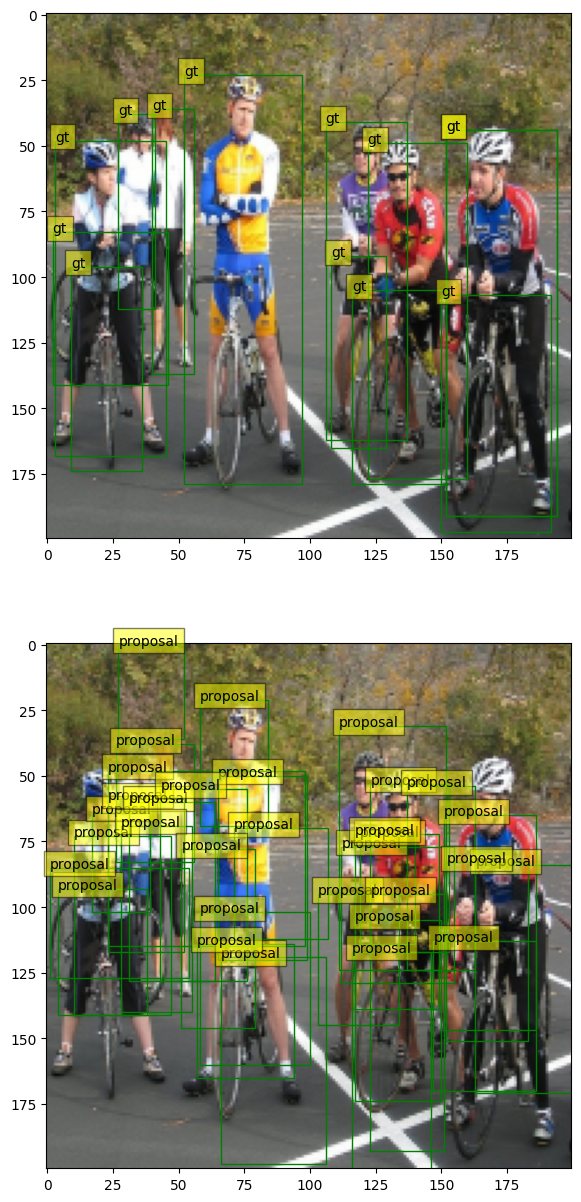

In [372]:
fig3, axes3 = plt.subplots(2, 1, figsize=(30, 15))
display_img([img_data_sample[0] , img_data_sample[0]], fig3, axes3)
display_boundingbox(gt_appear_in_an_img, ['gt' for i in range(gt_appear_in_an_img.shape[0])], fig3, axes3[0])
display_boundingbox(proposal.detach(), ['proposal' for i in range(proposal.shape[0])], fig3, axes3[1])